In [1]:
# File Name: ECCOv4r4_flux_time_series.ipynb

# Description: This jupyter notebook contains code that renders time-series plots of 
# many relevant oceanographic flux variables over the ECCO version 4 release 4 time period
# of 1992 - 2017. The author has chosen to operate on monthly_mean datasets as opposed 
# to daily_mean and/or daily_snap datasets for convenience.
# Attempts by the user were made to connect trends in the time-series plots to
#real-world phenomena, and each of the plots are explained from a mathematical point of view

# Initialize Python Libraries

In [3]:
## Import the ecco_v4_py library into Python
## =========================================
## -- If ecco_v4_py is not installed in your local Python library,
##    tell Python where to find it.  

import sys
sys.path.append('/scratch2/jcam98/CRIOS/ECCO_analysis_work/ECCOv4-py/ecco_v4_py') # sverdrup
sys.path.append('/work2/07674/jcam98/CRIOS/ECCO_analysis_work/ECCOv4-py/ecco_v4_py') # stampede2

import ecco_v4_py as ecco

''' Initialize Python libraries '''

import numpy as np
import pandas as pd
import requests
import shutil
import time as time
import glob
import matplotlib.pyplot as plt
#import xgcm

# to read and plot the downloaded NetCDF files
# assuming ecco_v4_py package has been installed in ECCOv4-py directory
# otherwise change sys.path.append as needed
import xarray as xr
from os.path import join,expanduser
import matplotlib.pyplot as plt

# for concurrent simulatenous downloads
from concurrent.futures import ThreadPoolExecutor
from getpass import getpass
from http.cookiejar import CookieJar
from io import StringIO
from itertools import repeat
from pathlib import Path
from platform import system
from netrc import netrc
from os.path import basename, isfile, isdir
# progress bar
from tqdm import tqdm
# library to download files
from urllib import request
from ecco_download import *

# Define file path to top-level eccov4r4 llc90 directories

eccov4r4_llc90_sverdrup = '/scratch2/jcam98/CRIOS/ECCO_analysis_work/datasets/v4r4/restruct_output/llc90'
eccov4r4_llc90_stampede2 = '/work2/07674/jcam98/CRIOS/ECCO_analysis_work/datasets/v4r4/restruct_output/llc90'




# Define Helper Subroutines

## Helper subroutine to log into NASA EarthData

In [4]:
def setup_earthdata_login_auth(machine: str, url: str='urs.earthdata.nasa.gov'):
    # look for the netrc file and use the login/password
    try:
        if (machine == "sverdrup"):
            username, _, password = netrc(file='/home/jcam98/.netrc').authenticators(url)
        elif (machine == "stampede2"):
            username, _, password = netrc(file='/home1/07674/jcam98/.netrc').authenticators(url)
    # if the file is not found, prompt the user for the login/password
    except (FileNotFoundError, TypeError):
        print('Please provide Earthdata Login credentials for access.')
        username, password = input('Username: '), getpass('Password: ')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, url, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

## Helper subroutines to make the API calls to search CMR and parse response

In [5]:
def set_params(params: dict):
    params.update({'scroll': "true", 'page_size': 2000})
    return {par: val for par, val in params.items() if val is not None}

def get_results(params: dict, headers: dict=None):
    response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.csv",
                            params=set_params(params),
                            headers=headers)
    return response, response.headers


def get_granules(params: dict):
    response, headers = get_results(params=params)
    scroll = headers['CMR-Scroll-Id']
    hits = int(headers['CMR-Hits'])
    if hits==0:
        raise Exception("No granules matched your input parameters.")
    df = pd.read_csv(StringIO(response.text))
    while hits > df.index.size:
        response, _ = get_results(params=params, headers={'CMR-Scroll-Id': scroll})
        data = pd.read_csv(StringIO(response.text))
        df = pd.concat([df, data])
    return df

## Helper subroutine to gracefully download single files and avoids re-downloading if file already exists

In [6]:
# To force redownload of the file, pass **True** to the boolean argument *force* (default **False**)
def download_file(url: str, output_dir: str, force: bool=False):
    """
    url (str): the HTTPS url from which the file will download
    output_dir (str): the local path into which the file will download
    force (bool): download even if the file exists locally already
    """
    if not isdir(output_dir):
        raise Exception(f"Output directory doesnt exist! ({output_dir})")

    target_file = join(output_dir, basename(url))

    # if the file has already been downloaded, skip
    if isfile(target_file) and force is False:
        print(f'\n{basename(url)} already exists, and force=False, not re-downloading')
        return 0

    with requests.get(url) as r:
        if not r.status_code // 100 == 2:
            raise Exception(r.text)
            return 0
        else:
            with open(target_file, 'wb') as f:
                total_size_in_bytes= int(r.headers.get('content-length', 0))
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

                return total_size_in_bytes

## Helper subroutine to download all urls in the list 'dls'

In [7]:
def download_files_concurrently(dls, download_dir, force=False):
    start_time = time.time()

    # use 3 threads for concurrent downloads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:

        # tqdm makes a cool progress bar
        results = list(tqdm(executor.map(download_file, dls, repeat(download_dir), repeat(force)), total=len(dls)))

        # add up the total downloaded file sizes
        total_download_size_in_bytes = np.sum(np.array(results))
        # calculate total time spent in the download
        total_time = time.time() - start_time

        print('\n=====================================')
        print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
        print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s') 

# Log into NASA Earthdata account using username and password

In [8]:
# Locally on Sverdrup
setup_earthdata_login_auth(machine = "sverdrup")

# Locally on Stampede2
#setup_earthdata_login_auth(machine = "stampede2")

# Opening Monthly Mean State Estimate Variable NetCDF Files

## Load files into python workspace using 'recursive_load_ecco_var_from_years_nc()'

In [9]:
llc90_monthly_means_data_dir_sverdrup = eccov4r4_llc90_sverdrup + \
                                        '/monthly_means/nctiles_monthly'

llc90_monthly_means_data_dir_stampede2 = eccov4r4_llc90_stampede2 + \
                                        '/monthly_means/nctiles_monthly'


# Define time range for time series 
year_start = 1992; year_end = 2017

########### Locally on Sverdrup ##############

# Load monthly mean datasets for heat flux properties
heat_flux_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
                            llc90_monthly_means_data_dir_sverdrup, \
                            vars_to_load=['EXFqnet', 'EXFhl', 'EXFhs', 'EXFlwnet', \
                            'EXFswnet', 'SIatmQnt'],\
                            years_to_load=range(year_start, year_end)).load()

# Load monthly mean datasets for freshwater flux properties
freshwater_flux_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
                            llc90_monthly_means_data_dir_sverdrup, \
                            vars_to_load=['EXFempmr', 'EXFevap', 'EXFpreci', 'EXFroff', \
                            'SIatmFW'],\
                            years_to_load=range(year_start, year_end)).load()

# Load monthly mean datasets for sea surface temperature (THETA) properties
SST_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
                        llc90_monthly_means_data_dir_sverdrup, \
                        vars_to_load=['THETA'],\
                        years_to_load=range(year_start, year_end)).load()

######### Locally on Stampede2 ################

# Load monthly mean datasets for heat flux properties
# heat_flux_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
#                             llc90_monthly_means_data_dir_stampede2, \
#                             vars_to_load=['EXFqnet', 'EXFhl', 'EXFhs', 'EXFlwnet', \
#                             'EXFswnet', 'SIatmQnt'],\
#                             years_to_load=range(year_start, year_end)).load()


# # Load monthly mean datasets for freshwater flux properties
# freshwater_flux_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
#                             llc90_monthly_means_data_dir_stampede2, \
#                             vars_to_load=['EXFempmr', 'EXFevap', 'EXFpreci', 'EXFroff', \
#                             'SIatmFW'],\
#                             years_to_load=range(year_start, year_end)).load()

# # Load monthly mean datasets for sea surface temperature (THETA) properties
# SST_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
#                         llc90_monthly_means_data_dir_stampede2, \
#                         vars_to_load=['THETA'],\
#                         years_to_load=range(year_start, year_end)).load()








loading files of  EXFhl
loading files of  EXFhs
loading files of  EXFlwnet
loading files of  EXFqnet
loading files of  EXFswnet
loading files of  SIatmQnt
loading files of  EXFempmr
loading files of  EXFevap
loading files of  EXFpreci
loading files of  EXFroff
loading files of  SIatmFW
loading files of  THETA


In [15]:
heat_flux_monthly_mean_ds.SIatmQnt

<xarray.DataArray 'SIatmQnt' (time: 300, tile: 13, j: 90, i: 90)>
array([[[[   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         ...,
         [ -91.00883   ,  -87.87189   ,  -84.68759   , ...,
          -112.30105   , -110.86654   , -109.34606   ],
         [ -93.57033   ,  -88.95941   ,  -83.64196   , ...,
          -114.15748   , -112.90897   , -110.838715  ],
         [ -97.5635    ,  -91.687836  ,  -85.102196  , ...,
          -115.95807   , -115.01442   , -112.56327   ]],

        [[-100.42977   ,  -94.76082   ,  -87.57909   , ...,
          -116.78461   , -115.831635  , -114.00627   ],
         [-101.19143   ,  -96.15989   ,  -89.726555  , ...,
          -120.24193   , -119.56409   , -118.79236   ],
         [-101.131325  ,  -96.05545   ,  -91.91944   , ...,
          -125.188736  , -125.168434  , -125.57722   ],
...
         [  87.62055   ,   79.7251    ,   72.89505   , ...,
          -129.05992   , -125.74277   , -124.334785  ],
         [  85.10752   ,   79.86841   ,   76.46287   , ...,
          -131.23372   , -128.111     , -127.02953   ],
         [  82.49591   ,   78.51049   ,   76.20908   , ...,
          -131.80226   , -129.20702   , -128.4277    ]],

        [[-114.1779    , -113.9331    , -114.66753   , ...,
             0.        ,    0.        ,    0.        ],
         [-114.846664  , -114.77507   , -115.7967    , ...,
             0.        ,    0.        ,    0.        ],
         [-114.31844   , -116.75319   , -119.84545   , ...,
             0.        ,    0.        ,    0.        ],
         ...,
         [-123.0861    , -121.80815   , -120.587944  , ...,
             0.        ,    0.        ,    0.        ],
         [-126.248276  , -125.15575   , -124.068474  , ...,
             0.        ,    0.        ,    0.        ],
         [-128.20605   , -127.36526   , -126.94635   , ...,
             0.        ,    0.        ,    0.        ]]]], dtype=float32)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1992-01-16T12:00:00 ... 2016-12-16T12:00:00
Attributes:
    units:          W/m^2
    long_name:      Net atmospheric heat flux, >0 decreases theta
    standard_name:  surface_downward_heat_flux_in_air

# Initiailize 'grid' object for storing ECCOv4r4 grid parameters

In [32]:
# Initialize grid object to store ECCOv4r4 grid parameters used in evaluating area-weighted
# flux properties 

# Define file path to nctiles_grid 'ECCO-GRID.nc'

############ Locally on Sverdrup #############
ecco_v4r4_grid_data_dir = eccov4r4_llc90_sverdrup + '/grid_files'

########## Locally on Stampede2 ##############
# ecco_v4r4_grid_data_dir = eccov4r4_llc90_stampede2 + '/grid_files'

# Define 'grid' object
ecco_v4r4_grid = ecco.load_ecco_grid_nc(ecco_v4r4_grid_data_dir, 'ECCO-GRID.nc')

# First, the areas of tracer grid cells masked in seawater must be separated from the areas
# covered by land using the "seawater area/total_area" ratio factor (hFacC)
area_masked = ecco_v4r4_grid.rA*ecco_v4r4_grid.hFacC.isel(k = 0).transpose('tile', 'j', 'i')

# Load dataset that stores the fraction of grid areas immersed in sea-ice
SI_area_monthly_mean_ds = ecco.recursive_load_ecco_var_from_years_nc(\
                            llc90_monthly_means_data_dir_sverdrup, \
                            vars_to_load=['SIarea'],\
                            years_to_load=range(year_start, year_end)).load()

# Drop redundant coordinates in flux xarray.Dataset objects that are contained in ecco grid object

heat_flux_monthly_mean_ds = heat_flux_monthly_mean_ds.reset_coords(drop = True)
freshwater_flux_monthly_mean_ds = freshwater_flux_monthly_mean_ds.reset_coords(drop = True)
SST_monthly_mean_ds = SST_monthly_mean_ds.reset_coords(drop = True)
SI_area_monthly_mean_ds.reset_coords(drop = True)

loading files of  SIarea


<xarray.Dataset>
Dimensions:  (j: 90, i: 90, tile: 13, time: 300, nv: 2)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1992-01-16T12:00:00 ... 2016-12-16T12:00:00
Dimensions without coordinates: nv
Data variables:
    SIarea   (time, tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/26)
    Conventions:                  CF-1.6
    Insitution:                   JPL
    Metadata_Conventions:         CF-1.6, Unidata Dataset Discovery v1.0, GDS...
    Project:                      Estimating the Circulation and Climate of t...
    author:                       Ou Wang and Ian Fenty
    cdm_data_type:                Grid
    ...                           ...
    product_time_coverage_end:    2017-12-31T12:00:00
    product_time_coverage_start:  1992-01-01T12:00:00
    product_version:              ECCO Version 4 Release 3 Extension (ECCOv4r...
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_start:          1992-01-01T00:00:00
    time_units:                   days since 1992-01-01 00:00:00

# Ocean Surface Heat Flux Time-Series Analysis

In [11]:
# Extract xarray.DataArray objects corresponding to each heat flux property in dataset

EXFqnet_arr = heat_flux_monthly_mean_ds.EXFqnet
EXFhl_arr = heat_flux_monthly_mean_ds.EXFhl
EXFhs_arr = heat_flux_monthly_mean_ds.EXFhs
EXFlwnet_arr = heat_flux_monthly_mean_ds.EXFlwnet
EXFswnet_arr = heat_flux_monthly_mean_ds.EXFswnet
SIatmQnt_arr = heat_flux_monthly_mean_ds.SIatmQnt
SIarea_arr = SI_area_monthly_mean_ds.SIarea


In [33]:
heat_flux_monthly_mean_ds.SIatmQnt

<xarray.DataArray 'SIatmQnt' (time: 300, tile: 13, j: 90, i: 90)>
array([[[[   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         ...,
         [ -91.00883   ,  -87.87189   ,  -84.68759   , ...,
          -112.30105   , -110.86654   , -109.34606   ],
         [ -93.57033   ,  -88.95941   ,  -83.64196   , ...,
          -114.15748   , -112.90897   , -110.838715  ],
         [ -97.5635    ,  -91.687836  ,  -85.102196  , ...,
          -115.95807   , -115.01442   , -112.56327   ]],

        [[-100.42977   ,  -94.76082   ,  -87.57909   , ...,
          -116.78461   , -115.831635  , -114.00627   ],
         [-101.19143   ,  -96.15989   ,  -89.726555  , ...,
          -120.24193   , -119.56409   , -118.79236   ],
         [-101.131325  ,  -96.05545   ,  -91.91944   , ...,
          -125.188736  , -125.168434  , -125.57722   ],
...
         [  87.62055   ,   79.7251    ,   72.89505   , ...,
          -129.05992   , -125.74277   , -124.334785  ],
         [  85.10752   ,   79.86841   ,   76.46287   , ...,
          -131.23372   , -128.111     , -127.02953   ],
         [  82.49591   ,   78.51049   ,   76.20908   , ...,
          -131.80226   , -129.20702   , -128.4277    ]],

        [[-114.1779    , -113.9331    , -114.66753   , ...,
             0.        ,    0.        ,    0.        ],
         [-114.846664  , -114.77507   , -115.7967    , ...,
             0.        ,    0.        ,    0.        ],
         [-114.31844   , -116.75319   , -119.84545   , ...,
             0.        ,    0.        ,    0.        ],
         ...,
         [-123.0861    , -121.80815   , -120.587944  , ...,
             0.        ,    0.        ,    0.        ],
         [-126.248276  , -125.15575   , -124.068474  , ...,
             0.        ,    0.        ,    0.        ],
         [-128.20605   , -127.36526   , -126.94635   , ...,
             0.        ,    0.        ,    0.        ]]]], dtype=float32)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1992-01-16T12:00:00 ... 2016-12-16T12:00:00
Attributes:
    units:          W/m^2
    long_name:      Net atmospheric heat flux, >0 decreases theta
    standard_name:  surface_downward_heat_flux_in_air

In [13]:
# Evaluate horizontally-integrated, area-weighted mean of heat flux properties to obtain 
# one resultant area-weighted mean value for each month in time period

EXFqnet_area_weighted = (EXFqnet_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFhl_area_weighted = (EXFhl_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFhs_area_weighted = (EXFhs_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFlwnet_area_weighted = (EXFlwnet_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFswnet_area_weighted = (EXFswnet_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

SIatmQnt_area_weighted = (SIatmQnt_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFqnet_residual_area_weighted = EXFqnet_area_weighted - (-EXFhl_area_weighted - \
                                 EXFhs_area_weighted + EXFlwnet_area_weighted + \
                                 EXFswnet_area_weighted)

# Convert area weighted xarray objects into numpy arrays for manipulation
EXFqnet_area_weighted_np = np.array(EXFqnet_area_weighted)
SIatmQnt_area_weighted_np = np.array(SIatmQnt_area_weighted)
EXFqnet_residual_area_weighted_np = np.array(EXFqnet_residual_area_weighted)
SI_area_np = np.array(SIarea_arr)


## Render Heat Flux Property Time-Series Plots 

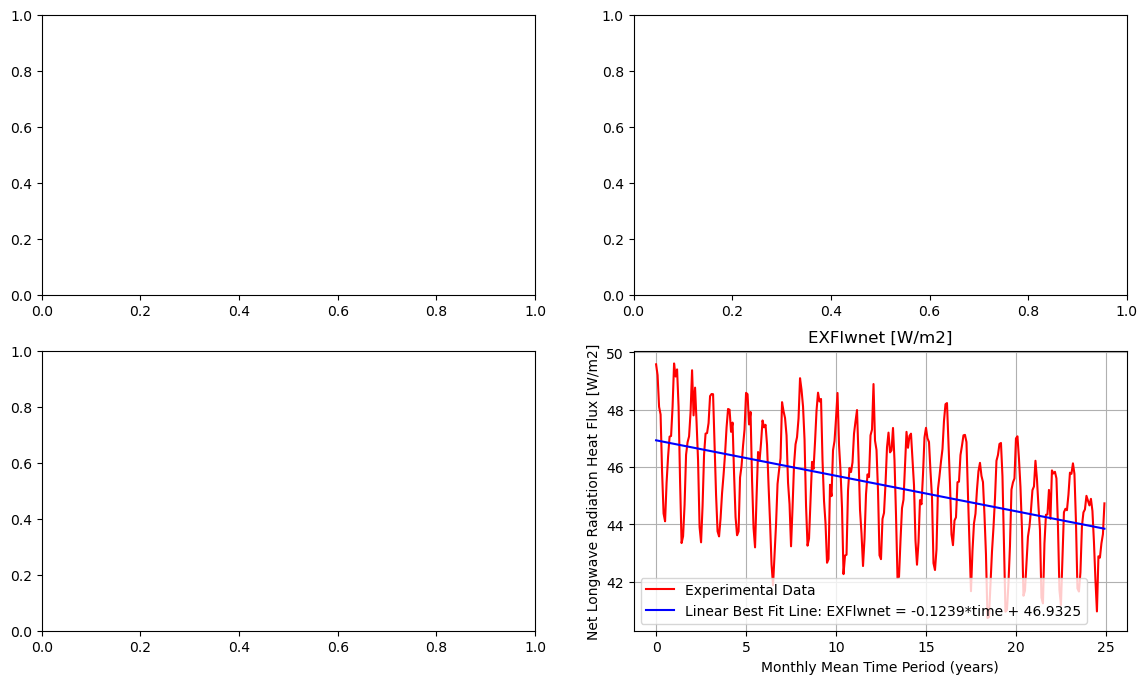

In [13]:
# Initialize figure geometry with four subplot grids for heat flux property visualizations

fig, axs = plt.subplots(2, 2, figsize = (14,8))
axs = axs.flatten()

# Convert xarray.DataArray objects storing heat flux property values into numpy arrays
# for linear regression model fitting

EXFhl_area_weighted_np = np.array(EXFhl_area_weighted)
EXFhs_area_weighted_np = np.array(EXFhs_area_weighted)
EXFswnet_area_weighted_np = np.array(EXFswnet_area_weighted)
EXFlwnet_area_weighted_np = np.array(EXFlwnet_area_weighted)

######## Time Series of Latent Heat Flux 

# Define numpy array with monthly mean time values

time = np.arange(1992, 2017, 1/12)
#time = np.arange(0, 25, 1/12)

# plt.sca(axs[0])
# axs[0].plot(time, EXFhl_area_weighted_np, color='r')

# # Fit Linear Regression Model to EXFhl Time-Series Data

# m, b = np.polyfit(time, EXFhl_area_weighted_np, 1) 
# m_r = round(m, 4)
# b_r = round(b, 4)

# # Render Linear Best Fit Line Plot 
# axs[0].plot(time, m*time + b, 'b')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Latent Heat Flux [W/m2]');
# plt.legend(['Experimental Data', 'Linear Best Fit Line: EXFhl = ' + str(m_r) + \
#             '*' + 'time + ' + str(b_r)]);
# plt.title("EXFhl [W/m2]")
# plt.grid()

######## Time Series of Sensible Heat Flux 

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

# plt.sca(axs[1])
# axs[1].plot(time, EXFhs_area_weighted_np,color='r')

# # Fit Linear Regression Model to EXFhs Time-Series Data

# m, b = np.polyfit(time, EXFhs_area_weighted_np, 1) 
# m_r = round(m, 4)
# b_r = round(b, 4)

# # Render Linear Best Fit Line Plot 
# axs[1].plot(time, m*time + b, 'b')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Sensible Heat Flux [W/m2]');
# plt.legend(['Experimental Data', 'Linear Best Fit Line: EXFhs = ' + str(m_r) + \
#             '*' + 'time + ' + str(b_r)]);
# plt.title("EXFhs [W/m2]")
# plt.grid()

# ######## Time Series of Shortwave Radiation Heat Flux 

time = np.arange(1992, 2017, 1/12)
#time = np.arange(0, 25, 1/12)

# plt.sca(axs[2])
# axs[2].plot(time, EXFswnet_area_weighted_np,color='r')

# # Fit Linear Regression Model to EXFswnet Time-Series Data

# m, b = np.polyfit(time, EXFswnet_area_weighted_np, 1) 
# m_r = round(m, 4)
# b_r = round(b, 4)

# # Render Linear Best Fit Line Plot 
# axs[2].plot(time, m*time + b, 'b')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Net Shortwave Radiation Heat Flux [W/m2]');
# plt.legend(['Experimental Data', 'Linear Best Fit Line: EXFswnet = ' + str(m_r) + \
#             '*' + 'time + ' + str(b_r)]);
# plt.title("EXFswnet [W/m2]")
# plt.grid()

# ######## Time Series of Longwave Radiation Heat Flux

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

plt.sca(axs[3])
axs[3].plot(time, EXFlwnet_area_weighted_np,color='r')

# Fit Linear Regression Model to EXFlwnet Time-Series Data

m, b = np.polyfit(time, EXFlwnet_area_weighted_np, 1) 
m_r = round(m, 4)
b_r = round(b, 4)

# Render Linear Best Fit Line Plot 
axs[3].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('Net Longwave Radiation Heat Flux [W/m2]');
plt.legend(['Experimental Data', 'Linear Best Fit Line: EXFlwnet = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)]);
plt.title("EXFlwnet [W/m2]")
plt.grid()

# #Render figure title
# plt.subplots_adjust(hspace = 1.0, wspace=.5)
# plt.suptitle('Globally-Integrated, Area-Weighted Mean Heat Flux Terms [W/m2]',
#                  fontsize=20);

## Interpretation of Heat Flux Property Time-Series Plots

### Similar to the previous experimental datasets, the experimental monthly-mean sea-surface temperature data from the ECCOv4r4 datasets (spanning a time period of 1992-2017), 'THETA' were concatenated into a single array, and the globally-integrated, area-weighted mean (global spatially-averaged) temperature values were obtained for each month in the time period. Then, a time-series line plot of the potential temperature at the sea surface was rendered as shown above, and a first degree polynomial was fit to the data. It is evident in this line plot that there is a positive linear trend between potential temperature and time with seasonal variations realized through annual periodic fluctuations shown in the steep inclines and declines throughout the plot. The former remark is realized through a linear regression model that appears to fit the data quite well. The annual periodic fluctuations are similar in shape over time and the annual maximum change in potential temperature over each of the yearly time periods remains relatively constant. These near annual invariabilities suggest to a large degree that while the spatially-averaged sea surface temperature has increased steadily from 1992 to 2017, it has done so while preserving spatially-averaged seasonal fluctuations in temperature within annual time segments.  

## Render Net Heat Flux and Net Heat Flux Residual Time-Series Plots

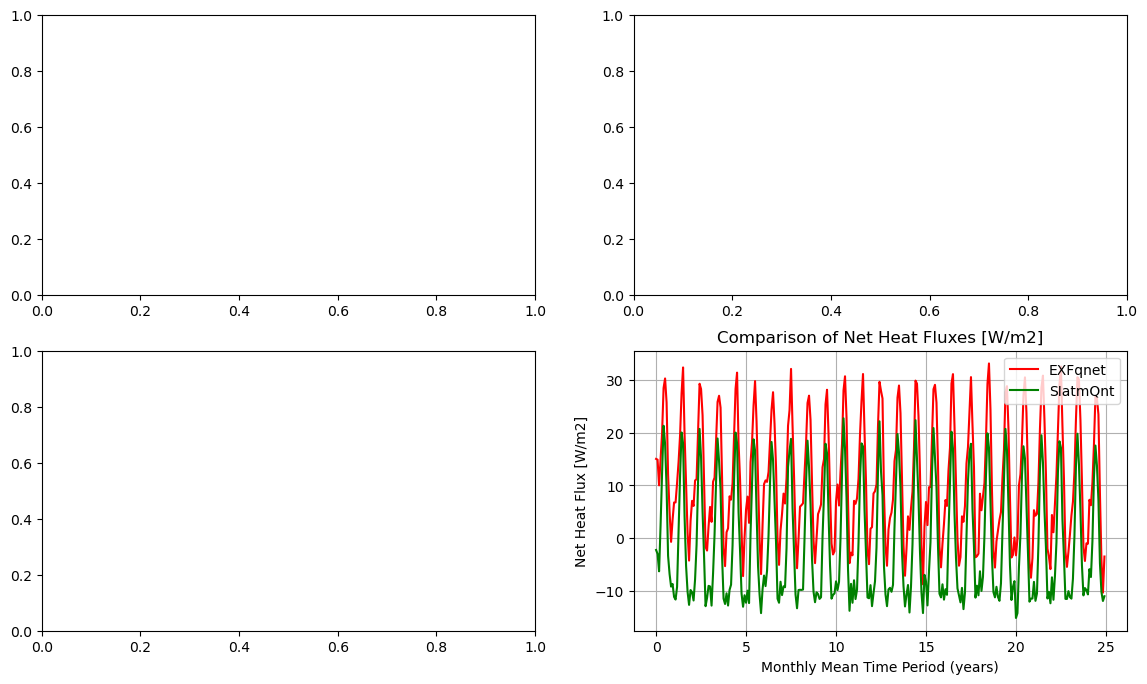

In [34]:
# Initiailize figure geometry with four subplot grids for net heat flux visualizations

fig, axs = plt.subplots(2, 2, figsize = (14,8))
axs = axs.flatten()

# ######## Time Series of Globally-Integrated, Area-Weighted Mean Net Heat Flux due to sea-ice- 
# ######## ocean surface transfer (atmosphere to ocean surface transfer in 
# ######## areas without ice cover)

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

# plt.sca(axs[0])
# axs[0].plot(time, EXFqnet_area_weighted_np,color='r')

# # Fit Linear Regression Model to EXFqnet Time-Series Data

# m, b = np.polyfit(time, EXFqnet_area_weighted_np, 1) 
# m_r = round(m, 4)
# b_r = round(b, 4)

# # Render Linear Best Fit Line Plot 
# axs[0].plot(time, m*time + b, 'b')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Net Heat Flux (Sea-Ice-Ocean Surface) [W/m2]');
# plt.legend(['Experimental Data', 'Linear Best Fit Line: EXFqnet = ' + str(m_r) + \
#             '*' + 'time + ' + str(b_r)]);
# plt.title("EXFqnet [W/m2]")
# plt.grid()

######## Time Series of area-weighted mean Net Heat Flux due to atmosphere-sea-ice transfer 

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

# plt.sca(axs[1])
# axs[1].plot(time, SIatmQnt_area_weighted, color='r')

# # Fit Linear Regression Model to EXFqnet Time-Series Data

# m, b = np.polyfit(time, SIatmQnt_area_weighted_np, 1) 
# m_r = round(m, 4)
# b_r = round(b, 4)

# # Render Linear Best Fit Line Plot 
# axs[1].plot(time, m*time + b, 'b')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Net Heat Flux (Atmosphere-Sea-Ice) [W/m2]');
# plt.legend(['Experimental Data', 'Linear Best Fit Line: SIatmQnt = ' + str(m_r) + \
#             '*' + 'time + ' + str(b_r)]);
# plt.title("SIatmQnt [W/m2]")
# plt.grid()

######## Heat Flux Residual due to Sea-Ice-Ocean Surface Transfer
######## (EXFqnet - (-EXFhl - EXFhs + EXFswnet + EXFlwnet))

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

# plt.sca(axs[2])
# axs[2].plot(time, EXFqnet_residual_area_weighted_np,color='r')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Heat Flux Residual (Sea-Ice-Ocean Surface) [W/m2]');
# plt.title("EXFqnet Residual[W/m2]")
# plt.grid()

# # Comparison of Net Heat Flux due to Sea-Ice-Ocean Surface Transfer 
# # to Net Heat Flux due to Sea-Ice-Ocean Surface Transfer 

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

plt.sca(axs[3])
axs[3].plot(time, EXFqnet_area_weighted_np, color = 'r')
axs[3].plot(time, SIatmQnt_area_weighted_np,color='g')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('Net Heat Flux [W/m2]');
plt.title("Comparison of Net Heat Fluxes [W/m2]")
plt.legend(['EXFqnet', 'SIatmQnt'])
plt.grid()

# # Render figure title
# plt.subplots_adjust(hspace = 1.0, wspace=.5)
# plt.suptitle('Globally-Integrated, Area-Weighted Mean Net Heat Fluxes [W/m2]',
#                  fontsize=20);

## Interpretation of Net Heat Flux Time Series Plots

### Similar to the previous experimental datasets, the experimental monthly-mean sea-surface temperature data from the ECCOv4r4 datasets (spanning a time period of 1992-2017), 'THETA' were concatenated into a single array, and the globally-integrated, area-weighted mean (global spatially-averaged) temperature values were obtained for each month in the time period. Then, a time-series line plot of the potential temperature at the sea surface was rendered as shown above, and a first degree polynomial was fit to the data. It is evident in this line plot that there is a positive linear trend between potential temperature and time with seasonal variations realized through annual periodic fluctuations shown in the steep inclines and declines throughout the plot. The former remark is realized through a linear regression model that appears to fit the data quite well. The annual periodic fluctuations are similar in shape over time and the annual maximum change in potential temperature over each of the yearly time periods remains relatively constant. These near annual invariabilities suggest to a large degree that while the spatially-averaged sea surface temperature has increased steadily from 1992 to 2017, it has done so while preserving spatially-averaged seasonal fluctuations in temperature within annual time segments.  

# Ocean Surface Freshwater Flux Time-Series Analysis

In [35]:
# Extract xarray.DataArray objects corresponding to each surface freshwater
# flux property in dataset

# negate 'EXFempmr' array so that positive values correspond 
# to net increase in freshwater flux into ocean not atmosphere
EXFempmr_arr = -freshwater_flux_monthly_mean_ds.EXFempmr 
EXFevap_arr = freshwater_flux_monthly_mean_ds.EXFevap
EXFroff_arr = freshwater_flux_monthly_mean_ds.EXFroff
EXFpreci_arr = freshwater_flux_monthly_mean_ds.EXFpreci
SIatmFW_arr = freshwater_flux_monthly_mean_ds.SIatmFW

# Convert surface freshwater flux (EXF) values from (m/s) to (mm/year) to be consistent with monthly mean data
EXFempmr_arr = EXFempmr_arr * ((365.25 * 24 * 60 * 60) / 1000)
EXFevap_arr = EXFevap_arr * ((365.25 * 24 * 60 * 60) / 1000)
EXFroff_arr = EXFroff_arr * ((365.25 * 24 * 60 * 60) / 1000)
EXFpreci_arr = EXFpreci_arr * ((365.25 * 24 * 60 * 60) / 1000)

# Convert net freshwater flux from atmosphere to sea-ice (SIatmFW_arr) from (kg/(m2 * s)) to (mm/year)

rho_fresh = 1000 # freshwater density in (kg/m3)
SIatmFW_arr = SIatmFW_arr * (1/rho_fresh) * ((365.25 * 24 * 60 * 60) / 1000)


In [36]:
# Evaluate horizontally-integrated, area-weighted mean of surface freshwater 
# flux properties to obtain one resultant mean value for each month in time period

EXFempmr_area_weighted = (EXFempmr_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFevap_area_weighted = (EXFevap_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFroff_area_weighted = (EXFroff_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFpreci_area_weighted = (EXFpreci_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

SIatmFW_area_weighted = (SIatmFW_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

EXFempmr_residual_area_weighted = EXFempmr_area_weighted - (EXFevap_area_weighted - \
                                 EXFroff_area_weighted - EXFpreci_area_weighted)



## Render Freshwater Flux  Time-Series Plots 

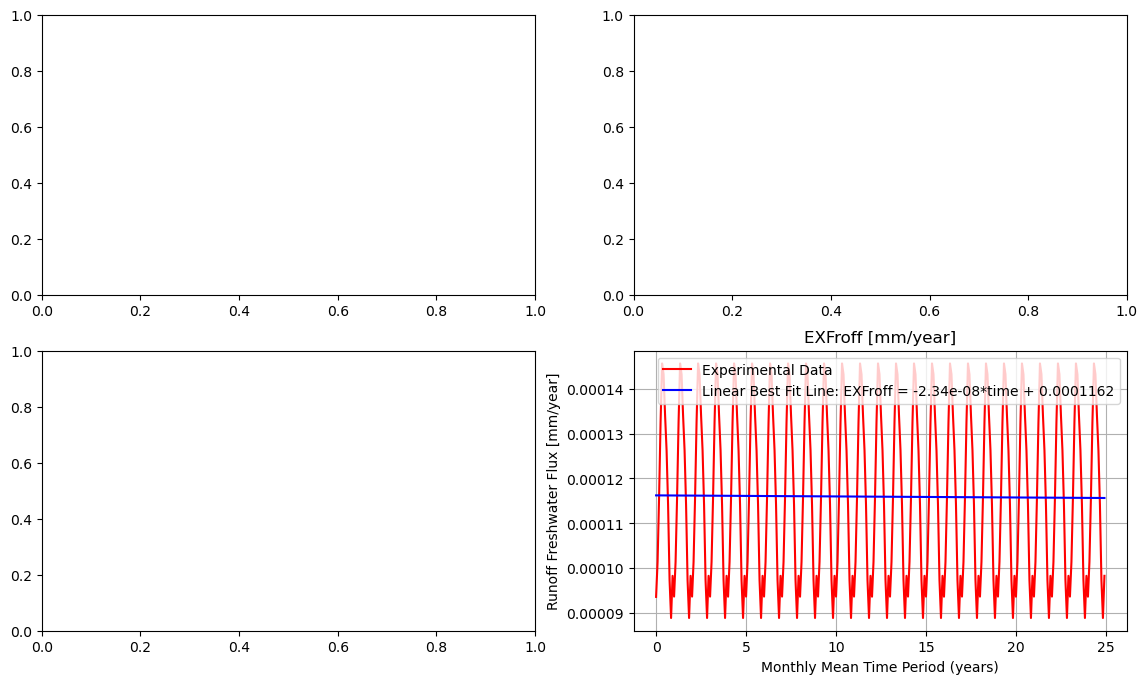

In [18]:
# Convert xarray.DataArray objects storing freshwater flux property values into numpy arrays
# for linear regression model fitting

EXFempmr_area_weighted_np = np.array(EXFempmr_area_weighted)
EXFevap_area_weighted_np = np.array(EXFevap_area_weighted)
EXFroff_area_weighted_np = np.array(EXFroff_area_weighted)
EXFpreci_area_weighted_np = np.array(EXFpreci_area_weighted)

# Initialize figure geometry with four subplot grids for freshwater flux property visualizations

fig, axs = plt.subplots(2, 2, figsize = (14,8))
axs = axs.flatten()

######## Time Series of Globally-integrated, Area-Weighted Mean Net Freshwater Flux due to
######## sea-ice-ocean surface transfer (atmosphere to ocean surface transfer in areas without
######## ice cover)

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

# plt.sca(axs[0])
# axs[0].plot(time, EXFempmr_area_weighted_np,color='r')

# # Fit Linear Regression Model to EXFempmr Time-Series Data

# m, b = np.polyfit(time, EXFempmr_area_weighted_np, 1) 
# m_r = round(m, 7)
# b_r = round(b, 7)

# # Render Linear Best Fit Line Plot 

# axs[0].plot(time, m*time + b, 'b')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Net Freshwater Flux (EXFempmr) [mm/year]');
# plt.legend(['Experimental Data', 'Linear Best Fit Line: EXFempmr = ' + str(m_r) + \
#             '*' + 'time + ' + str(b_r)]);
# plt.title("EXFempmr [mm/year]")
# plt.grid()

######## Time Series of Evaporative Freshwater Flux 

time = np.arange(1992, 2017, 1/12)
#time = np.arange(0, 25, 1/12)

# plt.sca(axs[1])
# axs[1].plot(time, EXFevap_area_weighted,color='r')

# # Fit Linear Regression Model to EXFevap Time-Series Data

# m, b = np.polyfit(time, EXFevap_area_weighted_np, 1) 
# m_r = round(m, 7)
# b_r = round(b, 7)

# # Render Linear Best Fit Line Plot 

# axs[1].plot(time, m*time + b, 'b')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Evaporative Freshwater Flux [mm/year]');
# plt.legend(['Experimental Data', 'Linear Best Fit Line: EXFevap = ' + str(m_r) + \
#             '*' + 'time + ' + str(b_r)]);
# plt.title("EXFevap [mm/year]")
# plt.grid()

# ######## Time Series of Precipitative Freshwater Flux 

time = np.arange(1992, 2017, 1/12)
#time = np.arange(0, 25, 1/12)

# plt.sca(axs[2])
# axs[2].plot(time, EXFpreci_area_weighted_np,color='r')
            
# # Fit Linear Regression Model to EXFpreci Time-Series Data

# m, b = np.polyfit(time, EXFpreci_area_weighted_np, 1) 
# m_r = round(m, 7)
# b_r = round(b, 7)

# # Render Linear Best Fit Line Plot 

# axs[2].plot(time, m*time + b, 'b')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Precipitative Freshwater Flux [mm/year]');
# plt.legend(['Experimental Data', 'Linear Best Fit Line: EXFpreci = ' + str(m_r) + \
#             '*' + 'time + ' + str(b_r)]);
# plt.title("EXFpreci [mm/year]")
# plt.grid()

# ######## Time Series of Runoff Freshwater Flux 

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

plt.sca(axs[3])
axs[3].plot(time, EXFroff_area_weighted_np,color='r')
            
# Fit Linear Regression Model to EXFroff Time-Series Data

m, b = np.polyfit(time, EXFroff_area_weighted_np, 1) 
m_r = round(m, 10)
b_r = round(b, 7)

# Render Linear Best Fit Line Plot 

axs[3].plot(time, m*time + b, 'b')
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('Runoff Freshwater Flux [mm/year]');
plt.legend(['Experimental Data', 'Linear Best Fit Line: EXFroff = ' + str(m_r) + \
            '*' + 'time + ' + str(b_r)]);
plt.title("EXFroff [mm/year]")
plt.grid()

# # Render figure title
# plt.subplots_adjust(hspace = 1.0, wspace=.5)
# plt.suptitle('Globally-Integrated, Area-Weighted Mean Freshwater Fluxes [W/m2]',
#                  fontsize=20);



## Interpretation of Freshwater Flux Property Time Series Plots

### Similar to the previous experimental datasets, the experimental monthly-mean sea-surface temperature data from the ECCOv4r4 datasets (spanning a time period of 1992-2017), 'THETA' were concatenated into a single array, and the globally-integrated, area-weighted mean (global spatially-averaged) temperature values were obtained for each month in the time period. Then, a time-series line plot of the potential temperature at the sea surface was rendered as shown above, and a first degree polynomial was fit to the data. It is evident in this line plot that there is a positive linear trend between potential temperature and time with seasonal variations realized through annual periodic fluctuations shown in the steep inclines and declines throughout the plot. The former remark is realized through a linear regression model that appears to fit the data quite well. The annual periodic fluctuations are similar in shape over time and the annual maximum change in potential temperature over each of the yearly time periods remains relatively constant. These near annual invariabilities suggest to a large degree that while the spatially-averaged sea surface temperature has increased steadily from 1992 to 2017, it has done so while preserving spatially-averaged seasonal fluctuations in temperature within annual time segments.  

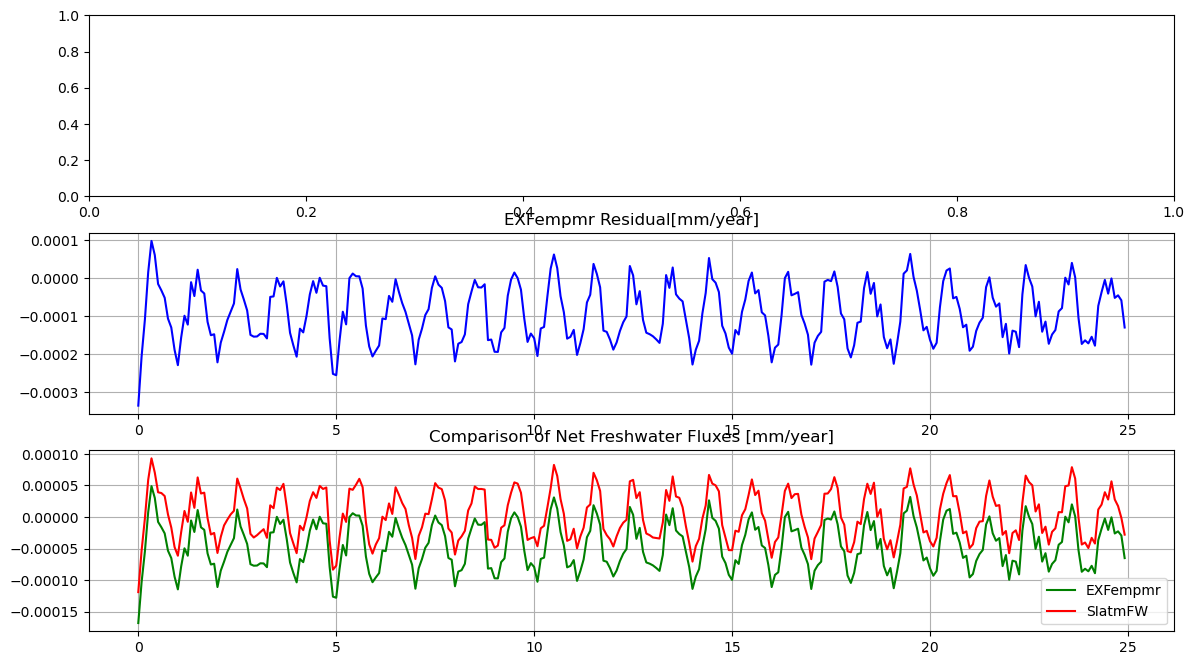

In [ ]:
# Convert xarray.DataArray objects storing freshwater flux property values into numpy arrays
# for linear regression model fitting

SIatmFW_area_weighted = np.array(SIatmFW_area_weighted)
EXFempmr_residual_area_weighted = np.array(EXFempmr_residual_area_weighted)

# Initialize figure geometry with three subplots grids for net freshwater flux visualizations

fig, axs = plt.subplots(3, 1, figsize = (14,8))
axs = axs.flatten()

# # Time Series of area-weighted mean Net Freshwater Flux due to atmosphere-
# # sea-ice transfer 

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

# plt.sca(axs[0])
# axs[0].plot(time, SIatmFW_area_weighted,color='r')
            
# # Fit Linear Regression Model to SIatmFW Time-Series Data

# m, b = np.polyfit(time, SIatmFW_area_weighted, 1) 
# m_r = round(m, 7)
# b_r = round(b, 7)

# # Render Linear Best Fit Line Plot 

# axs[0].plot(time, m*time + b, 'b')
# plt.xlabel('Monthly Mean Time Period (years)')
# plt.ylabel('Net Freshwater Flux (Atmosphere-Sea-Ice) [mm/year]');
# plt.legend(['Experimental Data', 'Linear Best Fit Line: SIatmFW = ' + str(m_r) + \
#             '*' + 'time + ' + str(b_r)]);
# plt.title("SIatmFW [mm/year]")
# plt.grid()

# # Freshwater Flux Residual due to Sea-Ice-Ocean Surface Transfer
# # (EXFempmr - (EXFevap - EXFpreci - EXFroff))

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

plt.sca(axs[1])
axs[1].plot(time, EXFempmr_residual_area_weighted,color='b')
plt.title("EXFempmr Residual[mm/year]")
plt.grid()

# # Comparison of Net Freshwater Flux due to Sea-Ice-Ocean Surface Transfer 
# # to Net Freshwater Flux due to sum of Atmosphere-Sea-Ice Transfer 

#time = np.arange(1992, 2017, 1/12)
time = np.arange(0, 25, 1/12)

plt.sca(axs[2])
axs[2].plot(time, EXFempmr_area_weighted,color='g')
axs[2].plot(time, SIatmFW_area_weighted,color='r')
plt.title("Comparison of Net Freshwater Fluxes [mm/year]")
plt.grid()
plt.legend(['EXFempmr', 'SIatmFW']);


# Render figure title
# plt.subplots_adjust(hspace = .5)
# plt.suptitle('Globally-Integrated, Area-Weighted Mean Freshwater Fluxes [mm/year]',
#                  fontsize=20);

## Interpretation of Net Freshwater Flux Time Series Plots

### Similar to the previous experimental datasets, the experimental monthly-mean sea-surface temperature data from the ECCOv4r4 datasets (spanning a time period of 1992-2017), 'THETA' were concatenated into a single array, and the globally-integrated, area-weighted mean (global spatially-averaged) temperature values were obtained for each month in the time period. Then, a time-series line plot of the potential temperature at the sea surface was rendered as shown above, and a first degree polynomial was fit to the data. It is evident in this line plot that there is a positive linear trend between potential temperature and time with seasonal variations realized through annual periodic fluctuations shown in the steep inclines and declines throughout the plot. The former remark is realized through a linear regression model that appears to fit the data quite well. The annual periodic fluctuations are similar in shape over time and the annual maximum change in potential temperature over each of the yearly time periods remains relatively constant. These near annual invariabilities suggest to a large degree that while the spatially-averaged sea surface temperature has increased steadily from 1992 to 2017, it has done so while preserving spatially-averaged seasonal fluctuations in temperature within annual time segments.  

# Ocean Surface Potential Temperature Time-Series Analysis

In [52]:
# Extract xarray.DataArray object corresponding to sea-surface temperature values

SST_arr = SST_monthly_mean_ds.THETA.isel(k = 0)
SST_time = np.arange(1992, 2017, 1/12)

In [53]:
# Evaluate Globally-Integrated Area-Weighted Mean of sea-surface temperature to obtain
# one resultant globally-integrated, area-weighted mean value for each month in time period

SST_area_weighted = (SST_arr * area_masked).sum(dim = ('i', 'j', 'tile')) \
                        /area_masked.sum()

## Render Time-Series Plots

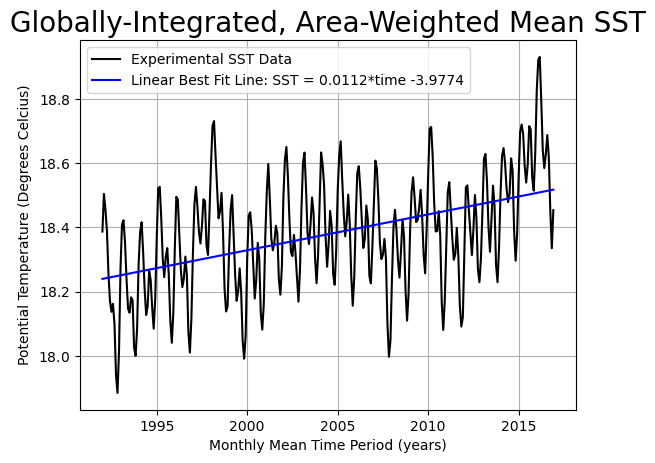

In [55]:
# Convert xarray.DataArray object storing SST values into numpy array for linear regression
# model fitting

SST_area_weighted_np = np.array(SST_area_weighted)

# Render Time Series Plot of Globally-Integrated, Area-Weighted Mean SST

time = np.arange(1992, 2017, 1/12)
#time = np.arange(0, 25, 1/12)

plt.plot(time, SST_area_weighted_np, color='k')
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('Globally-Integrated, Area-Weighted Mean SST',
                 fontsize=20)

# Fit Linear Regression Model to SST Time-Series Data

m, b = np.polyfit(time, SST_area_weighted_np, 1) 
m_r = round(m, 4)
b_r = round(b, 4)

# Render Linear Best Fit Line Plot 
plt.plot(time, m*time + b, 'b')
plt.grid()
plt.xlabel('Monthly Mean Time Period (years)')
plt.ylabel('Potential Temperature (Degrees Celcius)');
plt.legend(['Experimental SST Data', 'Linear Best Fit Line: SST = ' + str(m_r) + \
            '*' + 'time ' + str(b_r)]);




## Interpretation of SST Time Series Plot

Similar to the previous experimental datasets, the experimental monthly-mean sea-surface temperature data from the ECCOv4r4 datasets (spanning a time period of 1992-2017), 'THETA' were concatenated into a single array, and the globally-integrated, area-weighted mean (global spatially-averaged) temperature values were obtained for each month in the time period. Then, a time-series line plot of the potential temperature at the sea surface was rendered as shown above, and a first degree polynomial was fit to the data. It is evident in this line plot that there is a positive linear trend between potential temperature and time with seasonal variations realized through annual periodic fluctuations shown in the steep inclines and declines throughout the plot. The former remark is realized through a linear regression model that appears to fit the data quite well. The annual periodic fluctuations are similar in shape over time and the annual maximum change in potential temperature over each of the yearly time periods remains relatively constant. These near annual invariabilities suggest to a large degree that while the spatially-averaged sea surface temperature has increased steadily from 1992 to 2017, it has done so while preserving spatially-averaged seasonal fluctuations in temperature within annual time segments.   

# Analysis of Vertical Transport of Heat and Internal Heat Redistribution over multidecadal time period of 1993-2012

The purpose of this section will be to explore the multidecadal shift in
upper-layer temperature warming in the global ocean and any relationships
between cooling-warming compensation in different ocean basins over the
time period of 1993-2012. This analysis will be realized through line plots that examine the monthly mean spatially-integrated temperature variation with depth in each of the ocean basins in addition to oceanic isotherms that will depict zonal monthly mean temperature trends over the same basins. Efforts will then be made to compare these trends from the ECCO v4r4 datasets to temperature trends presented in a research article provided by Nieves, Willis, and Patzert. The researchers' results are applicable to the same time periods, and ocean basins, using a number of 
observational sources that differ from that of the sources of the author's ECCO v4r4 datasets. These are provided as follows: 
    

Observed Temperature Trends: 
    
1) World Ocean Atlas (WOA) 
2) Ishii
2) Scripps Institute of Oceanography (ARGO)

Simulated Temperature Trends (based on reanalyses that assimilate ocean data)

1) Simple Ocean Data Assimilation (SODA)
2) National Centers for Environmental Prediction Global Ocean Data Assimilation System (NCEP GODAS)
3) European Centre for Medium-Range Weather Forecasts ocean reanalysis system(ECMWF ORAS4)


    
    

## Global Mean Temperature Trends as a Function of Depth

In [112]:
THETA_arr = SST_monthly_mean_ds.THETA

# Index temperature data into three time periods and over depth range (0-1500 m)
# where a depth level of k = 0 corresponds to approximately 5 meters in depth
# and a depth level of k = 34, approximately 1517 meters in depth

THETA_90s = THETA_arr.isel(time = range(12,132), k = range(0,34))
THETA_00s = THETA_arr.isel(time = range(132,252), k = range(0,34))
THETA_00s_90s = THETA_arr.isel(time = range(12,252), k = range(0,34))

Z = -np.array(ecco_v4r4_grid.Z)
Z = Z[0:34]

# Evaluate Global Mean Temperature Variations as a function of depth for 
# depth range of ~ (0-1500 m) and over three
# time periods (1993-2002, 2003-2012, 1993-2012)

THETA_area_weighted_mean_90s = (THETA_90s * area_masked).sum(\
                         dim = ('i', 'j', 'tile')).mean('time') \
                        /(area_masked.sum())

THETA_area_weighted_mean_00s = (THETA_00s * area_masked).sum(\
                         dim = ('i', 'j', 'tile')).mean('time') \
                        /(area_masked.sum()) 

THETA_area_weighted_mean_00s_90s = (THETA_00s_90s * area_masked).sum(\
                         dim = ('i', 'j', 'tile')).mean('time') \
                        /(area_masked.sum())




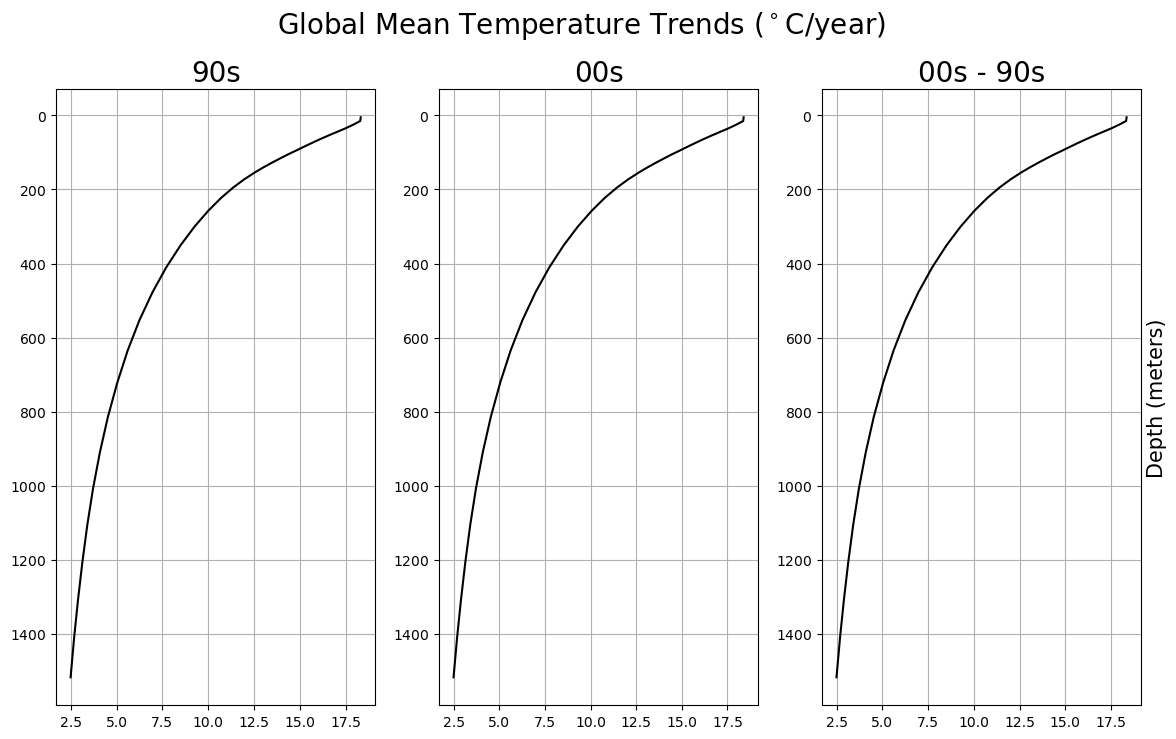

In [126]:
# Convert xarray.DataArray objects storing THETA values into numpy array for 
# linear regression model fitting

THETA_area_weighted_mean_90s = np.array(THETA_area_weighted_mean_90s)
THETA_area_weighted_mean_00s = np.array(THETA_area_weighted_mean_00s)
THETA_area_weighted_mean_00s_90s = np.array(THETA_area_weighted_mean_00s_90s)

# Initialize figure geometry with three subplot grids for global mean temp trends

fig, axs = plt.subplots(1, 3, figsize = (14,8))
axs = axs.flatten()

# Render Line Plot of Global Mean Temperature Trend for 1993 - 2002 
# (deg Celsius/year)

plt.sca(axs[0]) 
axs[0].plot(THETA_area_weighted_mean_90s, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('90s',fontsize=20)
plt.grid()

# Render Line Plot of Global Mean Temperature Trend for 2003 - 2012
# (deg Celsius/year)

plt.sca(axs[1]) 
axs[1].plot(THETA_area_weighted_mean_00s, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('00s',fontsize=20)
plt.grid()

# Render Line Plot of Global Mean Temperature Trend for 1993 - 2012 
# (deg Celsius/year)

plt.sca(axs[2]) 
axs[2].plot(THETA_area_weighted_mean_00s_90s, Z, color='k')
plt.gca().invert_yaxis()
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.title('00s - 90s',fontsize=20)
plt.grid()
plt.ylabel('Depth (meters)', fontsize = 15);
axs[2].yaxis.set_label_position("right")

#Render figure title
plt.suptitle('Global Mean Temperature Trends ($^\circ$C/year)',
                 fontsize=20);



## Regional Ocean Basin Mean Temperature Trends as a Function of Depth

In [ ]:
# Index temperature data into three time periods and over depth range (0-1500 m)
# where a depth level of k = 0 corresponds to approximately 5 meters in depth
# and a depth level of k = 34, approximately 1517 meters in depth

THETA_90s_pacific = THETA_arr.isel(time = range(12,132), k = range(0,34))
THETA_00s_pacific = THETA_arr.isel(time = range(132,252), k = range(0,34))
THETA_00s_90s_pacific = THETA_arr.isel(time = range(12,252), k = range(0,34))
THETA_90s_atlantic = THETA_arr.isel(time = range(12,132), k = range(0,34))
THETA_00s_atlantic = THETA_arr.isel(time = range(132,252), k = range(0,34))
THETA_00s_90s_atlantic = THETA_arr.isel(time = range(12,252), k = range(0,34))
THETA_90s_indian = THETA_arr.isel(time = range(12,132), k = range(0,34))
THETA_00s_indian = THETA_arr.isel(time = range(132,252), k = range(0,34))
THETA_00s_90s_indian = THETA_arr.isel(time = range(12,252), k = range(0,34))
THETA_90s_southern = THETA_arr.isel(time = range(12,132), k = range(0,34))
THETA_00s_southern = THETA_arr.isel(time = range(132,252), k = range(0,34))
THETA_00s_90s_southern = THETA_arr.isel(time = range(12,252), k = range(0,34))

Z = -np.array(ecco_v4r4_grid.Z)
Z = Z[0:34]

# Evaluate Global Mean Temperature Variations as a function of depth for 
# depth range of ~ (0-1500 m) and over three
# time periods (1993-2002, 2003-2012, 1993-2012)

THETA_area_weighted_mean_90s = (THETA_90s * area_masked).sum(\
                         dim = ('i', 'j', 'tile')).mean('time') \
                        /(area_masked.sum())

THETA_area_weighted_mean_00s = (THETA_00s * area_masked).sum(\
                         dim = ('i', 'j', 'tile')).mean('time') \
                        /(area_masked.sum()) 

THETA_area_weighted_mean_00s_90s = (THETA_00s_90s * area_masked).sum(\
                         dim = ('i', 'j', 'tile')).mean('time') \
                        /(area_masked.sum())

# RENDER ISOTHERM PLOTS HERE

TypeError: Input z must be 2D, not 3D

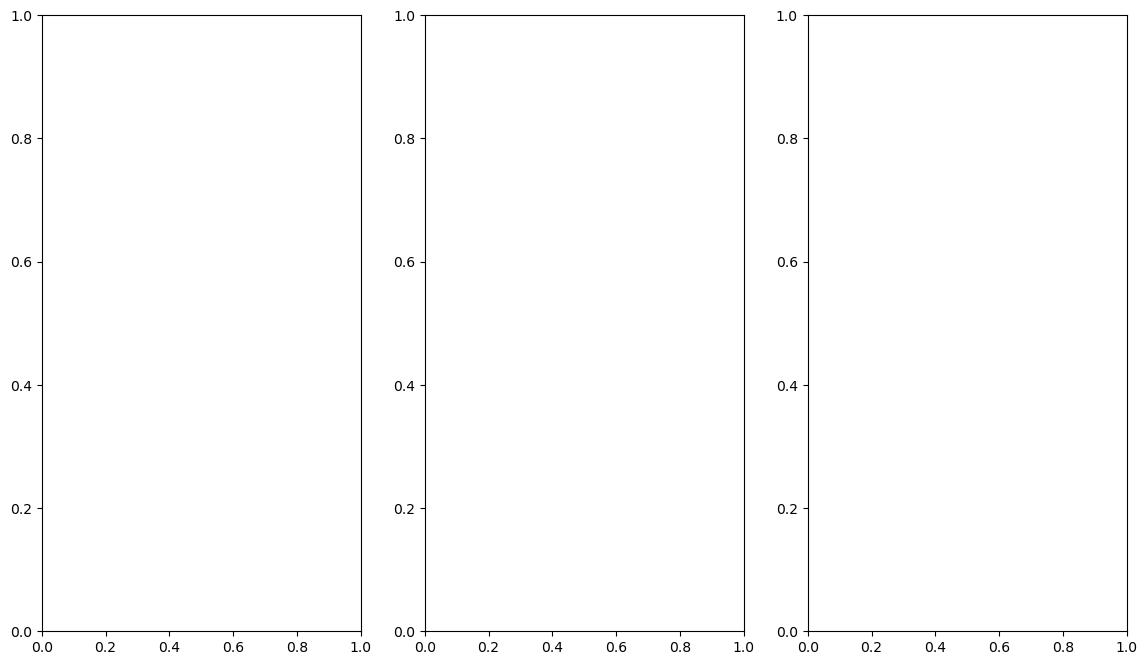

In [138]:
THETA_depth_integrated_90s = THETA_90s.mean('time').mean('k') 
THETA_depth_integrated_00s = THETA_00s.mean('time').mean('k') 
THETA_depth_integrated_00s_90s = THETA_00s_90s.mean('time').mean('k') 
                            
####### Render global temperature trends averaged over depth and time

# Initialize figure geometry with three subplot grids for global mean temp trends

fig, axs = plt.subplots(1, 3, figsize = (14,8))
axs = axs.flatten()

# Render Mean Temperature Trend for 1993 - 2002 (deg Celsius/year)

plt.sca(axs[0]) 

# ecco.plot_proj_to_latlon_grid(ecco_v4r4_grid.XC, ecco_v4r4_grid.YC, THETA_depth_integrated_90s,show_colorbar=True,
#                               cmin=-5e-6, cmax=5e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);

# ecco.plot_proj_to_latlon_grid(ecco_v4r4_grid.XC, ecco_v4r4_grid.YC, THETA_depth_integrated_00s,show_colorbar=True,
#                               cmin=-5e-6, cmax=5e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);

# ecco.plot_proj_to_latlon_grid(ecco_v4r4_grid.XC, ecco_v4r4_grid.YC, THETA_depth_integrated_00s_90s,show_colorbar=True,
#                               cmin=-5e-6, cmax=5e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);

plt.contour(np.array(ecco_v4r4_grid.XC), np.array(ecco_v4r4_grid.YC), np.array(THETA_depth_integrated_90s))

#THETA_depth_integrated_90s.plot(cmap = 'seismic')


# densanom_surf_plot = (densanom_surf.isel(tile=1)).plot(cmap='seismic')

# # Render Line Plot of Global Mean Temperature Trend for 1993 - 2002 
# # (deg Celsius/year)

# plt.sca(axs[0]) 
# axs[0].plot(THETA_area_weighted_mean_90s, Z, color='k')
# plt.gca().invert_yaxis()
# plt.ticklabel_format(axis='y', style='sci', useMathText=True)
# plt.title('90s',fontsize=20)
# plt.grid()

# # Render Line Plot of Global Mean Temperature Trend for 1993 - 2002 
# # (deg Celsius/year)

# plt.sca(axs[0]) 
# axs[0].plot(THETA_area_weighted_mean_90s, Z, color='k')
# plt.gca().invert_yaxis()
# plt.ticklabel_format(axis='y', style='sci', useMathText=True)
# plt.title('90s',fontsize=20)
# plt.grid()